In [221]:
import numpy as np
import pandas as pd
import json
import requests
from datetime import datetime
import matplotlib.pyplot as plt

## Step 1: Data acquisition
We will collect monthly data on web traffic (desktop and mobile traffic) to English Wikipedia from two Wikipedia APIs and save the data in seperate JSON files. The API requests are in python code below:

Pagecount Requests & Pageview Requests

In [222]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

## Step 2: API call
We will set the parameters to request legacy counts of desktop and mobile clicks on wikipedia.org (english) on monthly basis for the date range December 2007 to July 2016. Similarly, we set the parameters to request pageview countsof desktop and mobile (web & app) clicks for the date range July 2015 to August 2019 

In [223]:

desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016073100"
                    }

mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016073100"
                    }

desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019083100'
                        }

mobileapp_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019083100'
                        }
mobileweb_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019083100'
                        }

headers = {
    'User-Agent': 'https://github.com/kamalavj',
    'From': 'kamalavj@uw.edu'
}

## Function that requests the API and returns the requested data in json format

In [224]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

## Step 3: The requested data from the respective API calls is stored into a JSON file with the appropriate filename

In [225]:
monthly_desktop_legacy = api_call(endpoint_legacy, desktop_params_legacy)
monthly_mobile_legacy = api_call(endpoint_legacy, mobile_params_legacy)
monthly_desktop_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews)
monthly_mobileapp_pageviews = api_call(endpoint_pageviews, mobileapp_params_pageviews)
monthly_mobileweb_pageviews = api_call(endpoint_pageviews, mobileweb_params_pageviews)


response_data = [monthly_desktop_legacy, monthly_mobile_legacy, monthly_desktop_pageviews, monthly_mobileapp_pageviews, monthly_mobileweb_pageviews]

filenames = ["pagecounts_desktop-site_200712-201607.json",
             "pagecounts_mobile-site_200712-201607.json",
             "pageviews_desktop_201507-201908.json",
             "pageviews_mobile-web_201507-201908.json",
             "pageviews_mobile-app_201507-201908.json"]
count = 0
for filename in filenames:
        with open(filename, "w") as f:
            json.dump(response_data[count], f)
            count+=1

## Step 4: Each api call is stored into a dataframe. These dataframes are stored in a list.  All these dataframes are merged on the timestamp that is set as index. The nans are filtered from the merged dataframe. The appropriate columns are renamed or dropped to obtain the final dataframe

In [226]:
dataframes = []
access = ['desktop-count', 'mobile-count', 'desktop-views', 'mobile-web-views', 'mobile-app-views']
count=0
for json_file in response_data:
        df = pd.DataFrame(json_file['items'])
        name = access[count]
        df['timestamp'] = (pd.to_datetime(df['timestamp'],format='%Y%m%d%f', errors='ignore'))
        df = df.set_index('timestamp')
        if 'views' in df.columns:
            df[name] = df['views']
            df = df.drop(['agent','granularity','project','access','views'],axis=1)
                    
        else:
            df[name] = df['count']
            df = df.drop(['granularity','project','access-site','count'],axis=1)

        dataframes.append(df)
        count+=1


combined_df = pd.concat( dataframes, axis = 1).fillna(0)
combined_df['year'] = pd.DatetimeIndex(combined_df.index).year
combined_df['month'] = pd.DatetimeIndex(combined_df.index).month
combined_df['pagecount_desktop_views'] = combined_df['desktop-count']
combined_df['pagecount_mobile_views'] = combined_df['mobile-count']
combined_df['pagecount_all_views'] = combined_df['pagecount_desktop_views'] + combined_df['pagecount_mobile_views']
combined_df['pageview_desktop_views'] = combined_df['desktop-views']
combined_df['pageview_mobile_views'] = combined_df['mobile-web-views']+combined_df['mobile-app-views']
combined_df['pageview_all_views'] = combined_df['pageview_desktop_views']+combined_df['pageview_mobile_views']

In [227]:
combined_df = combined_df.drop(access, axis = 1)
combined_df = combined_df.reset_index()
combined_df = combined_df.drop('timestamp',axis =1)

In [228]:
combined_df

,year,month,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views,pageview_desktop_views,pageview_mobile_views,pageview_all_views
0,2007,12,2.998332e+09,0.0,2.998332e+09,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,1,4.930903e+09,0.0,4.930903e+09,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,2,4.818394e+09,0.0,4.818394e+09,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,3,4.955406e+09,0.0,4.955406e+09,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,4,5.159162e+09,0.0,5.159162e+09,0.000000e+00,0.000000e+00,0.000000e+00
5,2008,5,5.584691e+09,0.0,5.584691e+09,0.000000e+00,0.000000e+00,0.000000e+00
6,2008,6,5.712104e+09,0.0,5.712104e+09,0.000000e+00,0.000000e+00,0.000000e+00
7,2008,7,5.306303e+09,0.0,5.306303e+09,0.000000e+00,0.000000e+00,0.000000e+00
8,2008,8,5.140156e+09,0.0,5.140156e+09,0.000000e+00,0.000000e+00,0.000000e+00
9,2008,9,5.479534e+09,0.0,5.479534e+09,0.000000e+00,0.000000e+00,0.000000e+00


## Step 5: The dataframe is stored into a csv file

In [229]:
csv_file = 'en-wikipedia_traffic_200712-201809.csv'
combined_df.to_csv(csv_file)

## Step 6: The data is visualized using matplotlib and the figure plot is saved 

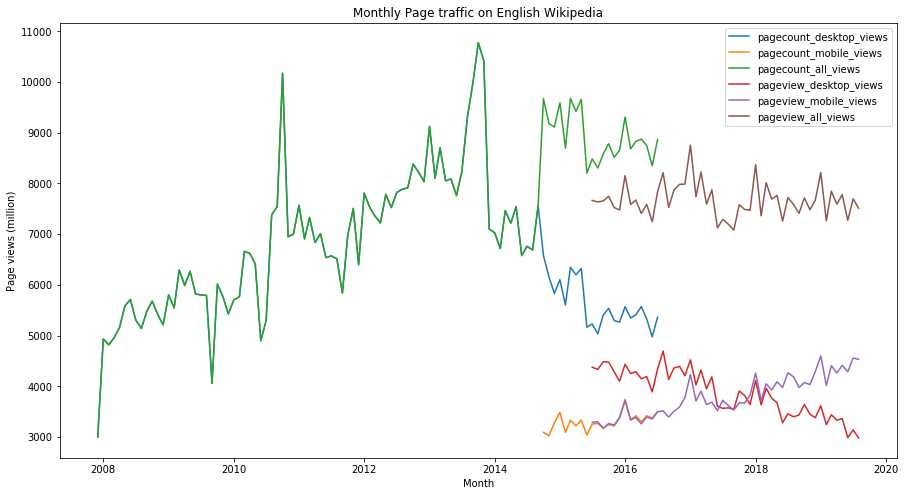

In [232]:
fig, ax = plt.subplots(figsize=(15, 8))

final_plot = combined_df
final_plot['date'] = final_plot['year'].map(str)+ '/' +final_plot['month'].map(str)
final_plot['date'] = pd.to_datetime(final_plot['date'], format='%Y-%m')
final_plot = final_plot.replace({0:np.nan})
fields = final_plot.drop(['year','month','date'],axis=1)
i = 0
for field in fields:
    yn = fields[field]/1000000
    ax.plot(final_plot['date'],yn,label=field)
    i+=1

ax.set(xlabel="Month", ylabel="Page views (million)",
       title="Monthly Page traffic on English Wikipedia")

plt.legend()
fig = plt.gcf()
plt.show()


fig.savefig('Monthly_wikipage_traffic.png')